**Number of editors by user edit bucket shown using voilin plot for wikis(tewiki, hiwiki, mlwiki)**

Running query on tewiki...
Running query on hiwiki...
Running query on mlwiki...


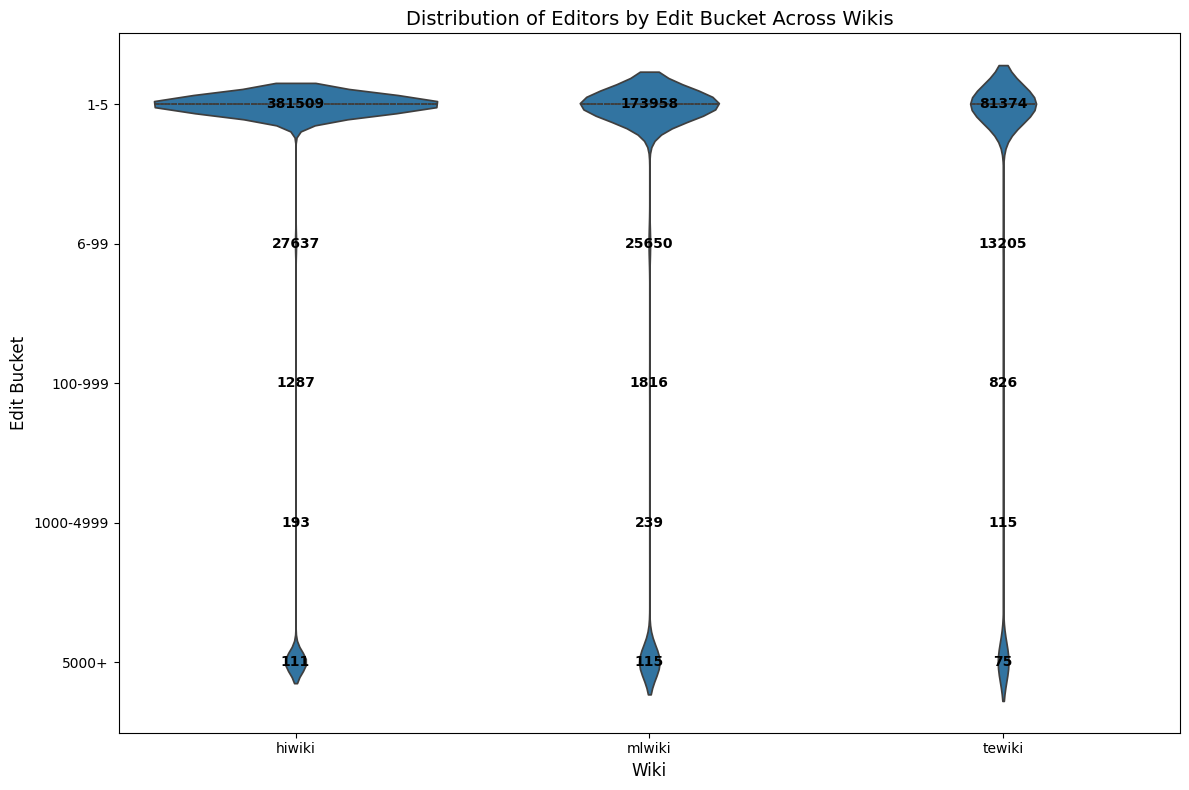

In [24]:
# Import statement
import pymysql
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt

# Function to connect and query
def connect_and_query(wiki_name, query, cnf_path="/home/paws/.my.cnf"):
    conn = pymysql.connect(
        host=wiki_name + '.analytics.db.svc.wikimedia.cloud',
        read_default_file=cnf_path,
        database=wiki_name + '_p'
    )
    
    with conn.cursor() as cur:
        cur.execute(query)
        data = cur.fetchall()
        colnames = [desc[0] for desc in cur.description]
    
    conn.close()
    return pd.DataFrame(data, columns=colnames)

#  Define wikis and fetch SQL query 
wikis = ['tewiki', 'hiwiki', 'mlwiki']
query_url = "https://raw.githubusercontent.com/venkataeswarachi/community-insights-dashboard-tooling/main/Number_of_editors_by_user_edit_bucket.sql"
query1 = requests.get(query_url).text

#clean sql query
query_lines = [line.strip() for line in query1.split('\n') if line.strip() and not line.strip().startswith('--')]
cleaned_query = ' '.join(query_lines)

# Execute the query across all wikis 
all_dfs = []
for wiki in wikis:
    print(f"Running query on {wiki}...")
    df = connect_and_query(wiki, cleaned_query)
    df['wiki'] = wiki  # Label each row with its wiki source
    all_dfs.append(df)

# Combine all results into one DataFrame 
combined_df = pd.concat(all_dfs, ignore_index=True) 

#Sort combined_df by wiki alphabetically 
combined_df = combined_df.sort_values('wiki')

#  Create sorted wiki list and bucket order 
wiki_order = sorted(combined_df['wiki'].unique())  

# Sort buckets by total number_of_editors (ascending)
bucket_totals = combined_df.groupby('bucket')['number_of_editors'].sum()
bucket_order = bucket_totals.sort_values(ascending=False).index.tolist() 


exploded_df = combined_df.loc[combined_df.index.repeat(combined_df['number_of_editors'])].reset_index(drop=True)


plt.figure(figsize=(12, 8))

# Create violin plot 
ax = sns.violinplot(
    data=exploded_df,
    x='wiki',
    y='bucket',
    inner='quartile',
    density_norm='count',
    order=wiki_order,       
)

# Set the y-axis order manually
ax.set_yticks(range(len(bucket_order)))
ax.set_yticklabels(bucket_order)

# Add number annotations on the plot
for wiki_idx, wiki in enumerate(wiki_order):
    for bucket_idx, bucket in enumerate(bucket_order):
        # Get the count for this wiki-bucket combination to show how many editors in that range
        count = combined_df[(combined_df['wiki'] == wiki) & (combined_df['bucket'] == bucket)]['number_of_editors'].sum()
        if count > 0: 
            ax.text(wiki_idx, bucket_idx, str(int(count)), 
                   ha='center', va='center', fontweight='bold', 
                   fontsize=10, color='black') 
                   

plt.title('Distribution of Editors by Edit Bucket Across Wikis', fontsize=14)
plt.xlabel('Wiki', fontsize=12)
plt.ylabel('Edit Bucket', fontsize=12)
plt.tight_layout()
plt.show()



Number of unique users by user right currently shown in table format for wikis (tewiki,hiwiki,mlwiki)

In [25]:
import pandas as pd
import requests

# wikis list
wikis = ['tewiki', 'hiwiki', 'mlwiki']

# URL to for SQL query
query_url = "https://raw.githubusercontent.com/venkataeswarachi/community-insights-dashboard-tooling/main/Number_of_unique_user_by_user_right_currently.sql"
query = requests.get(query_url).text


all_dfs = []
wiki_tables = {}

# Execute query for each wiki and display individual tables
for wiki in wikis:
    print(f"Running query on {wiki}...")
    df = connect_and_query(wiki, query)
    df['wiki'] = wiki
    wiki_tables[wiki] = df
    
    # Display individual table for each wiki
    print(f"\n{'='*50}")
    print(f"Results for {wiki.upper()}")
    print(f"{'='*50}")
    pd.set_option('display.max_rows', 100)
    pd.set_option('display.max_columns', None)
    display(df)
    
    # Summary for each wiki
    total_users = df['unique_users'].sum()
    print(f"Total users with rights in {wiki}: {total_users}")
    print(f"Number of different user rights: {len(df)}")



Running query on tewiki...

Results for TEWIKI


,ug_group,unique_users,wiki
0,b'bot',53,tewiki
1,b'sysop',11,tewiki
2,b'bureaucrat',4,tewiki


Total users with rights in tewiki: 68
Number of different user rights: 3
Running query on hiwiki...

Results for HIWIKI


,ug_group,unique_users,wiki
0,b'bot',14,hiwiki
1,b'sysop',7,hiwiki


Total users with rights in hiwiki: 21
Number of different user rights: 2
Running query on mlwiki...

Results for MLWIKI


,ug_group,unique_users,wiki
0,b'bot',88,mlwiki
1,b'sysop',14,mlwiki
2,b'bureaucrat',2,mlwiki
3,b'checkuser',2,mlwiki


Total users with rights in mlwiki: 106
Number of different user rights: 4
